In [1]:
#|export
import subprocess
import os
import time
import psutil
import struct
import numpy as np
import pandas as pd
import torch
import csv
from datetime import datetime
import platform

from export import export_model, export_modelq8
from train import load

In [2]:
#|export
def run_c(dir_path, base_command, model_path):
    '''Run C inference and return dictionary with accuracy, duration, model size, and memory usage.'''
    # get file paths of images and their labels
    files = []
    for label in range(10):
        sd_path = os.path.join(dir_path, str(label))
        f_paths = [os.path.join(sd_path, file) for file in os.listdir(sd_path)]
        files += f_paths

    # run C inference
    command = [base_command, model_path, *files]
    mems = []

    start_time = time.time()
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    proc = psutil.Process(process.pid)
    while process.poll() == None:
        try:
            # `proc.memory_info().rss` returns the physical memory the process has used
            mems.append(proc.memory_info().rss / (1024 * 1024)) # append in megabytes
            time.sleep(0.1)  # check memory usage every 0.1 second
        except psutil.NoSuchProcess: # handle the case where the process ends abruptly
            pass
    end_time = time.time()

    output, _ = process.communicate()
    acc = float(output.decode().strip())
    dur = end_time - start_time
    model_size = os.path.getsize(model_path) / (1024 * 1024)
    d = {"Accuracy": acc, "Time": dur, "Model size": model_size, "Memory usage": mems}

    return d


def run_python(dir_path, model_path):
    '''Run Python inference and return dictionary with accuracy, duration, model size, and memory usage.'''
    command = ["python", "run.py", model_path, dir_path]
    mems = []

    start_time = time.time()
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    proc = psutil.Process(process.pid)
    while process.poll() == None:
        try:
            # `proc.memory_info().rss` returns the physical memory the process has used
            mems.append(proc.memory_info().rss / (1024 * 1024)) # append in megabytes
            time.sleep(0.1)  # check memory usage every 0.1 second
        except psutil.NoSuchProcess: # handle the case where the process ends abruptly
            pass
    end_time = time.time()

    output, _ = process.communicate()
    acc = float(output.decode().strip())
    dur = end_time - start_time
    model_size = os.path.getsize(model_path) / (1024 * 1024)
    d = {"Accuracy": acc, "Time": dur, "Model size": model_size, "Memory usage": mems}

    return d

In [3]:
#|export
# Generate model files for tinyRuntime
path = "data"
model = load("resnet18").model
export_model(model, "model.bin")
export_modelq8(model, "model-q8.bin")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

wrote model.bin
Quantized (64, 3, 7, 7) to Q8_0 with max error 0.00399431586265564
Quantized (64, 64, 3, 3) to Q8_0 with max error 0.0030971625819802284
Quantized (64, 64, 3, 3) to Q8_0 with max error 0.0018653776496648788
Quantized (64, 64, 3, 3) to Q8_0 with max error 0.0025304292794317007
Quantized (64, 64, 3, 3) to Q8_0 with max error 0.0014979839324951172
Quantized (128, 64, 3, 3) to Q8_0 with max error 0.0012937188148498535
Quantized (128, 128, 3, 3) to Q8_0 with max error 0.0016725650057196617
Quantized (128, 64, 1, 1) to Q8_0 with max error 0.0030133600812405348
Quantized (128, 128, 3, 3) to Q8_0 with max error 0.001718759536743164
Quantized (128, 128, 3, 3) to Q8_0 with max error 0.0013971449807286263
Quantized (256, 128, 3, 3) to Q8_0 with max error 0.0015289076836779714
Quantized (256, 256, 3, 3) to Q8_0 with max error 0.0013069347478449345
Quantized (256, 128, 1, 1) to Q8_0 with max error 0.0010194750502705574
Quantized (256, 256, 3, 3) to Q8_0 with max error 0.001156233251

In [4]:
# NOTE: rerunning decrease memory usage in notebook, Python possible use previously allocated memory
res0 = run_python(path, "model.pkl")
res0["Accuracy"], res0["Time"]

(99.0, 10.572875022888184)

In [5]:
res1 = run_c(path, "./run", "model.bin")
res1["Accuracy"], res1["Time"]

(99.0, 1.173017978668213)

In [6]:
res2 = run_c(path, "./runq", "model-q8.bin")
res2["Accuracy"], res2["Time"]

(99.0, 1.6706881523132324)

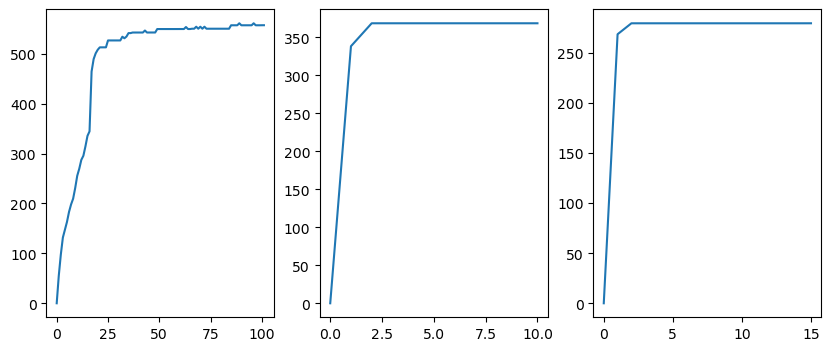

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].plot(res0["Memory usage"])
ax[1].plot(res1["Memory usage"])
ax[2].plot(res2["Memory usage"])

In [8]:
#|export
def compare_results(res, architecture, runtime, quantized):
    '''Compare the results and fail if performance is worse compared to the previous result'''
    df = pd.read_csv("benchmark.csv")
    df = df[(df["Architecture"] == architecture) & (df["Runtime"] == runtime) & (df["Quantization"] == quantized)]
    if res["Accuracy"] < 0.9 * df["Accuracy"].values[-1]:
        raise ValueError(f"{runtime} - {quantized}: Accuracy is worse than 10%")
    if res["Time"] > 1.25 * df["Time"].values[-1]:
        raise ValueError("{runtime} - {quantized}: Time is worse than 25%.")

def save_benchmark_csv():
    # Get results
    commit_id = os.getenv('GITHUB_SHA')
    time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    architecture = platform.machine()
    res0 = run_python(path, "model.pkl")
    res1 = run_c(path, "./run", "model.bin")
    res2 = run_c(path, "./runq", "model-q8.bin")
    # raise error if performance is worse than earlier
    compare_results(res0, architecture, "PyTorch", False)
    compare_results(res1, architecture, "tinyRuntime", False)
    compare_results(res2, architecture, "tinyRuntime", True)

    def generate_dict(res, runtime, quantization=False):
        d = {"Commit": commit_id, "Datetime": time, "Architecture": architecture, "Runtime": runtime,
             "Quantization": quantization, "Accuracy": res["Accuracy"], "Time": res["Time"],
             "Model size": res["Model size"], "Max memory": np.max(res["Memory usage"])}
        return d

    data = [generate_dict(res0, "PyTorch"), generate_dict(res1, "tinyRuntime"),
            generate_dict(res2, "tinyRuntime", quantization=True)]

    # Write results
    csv_file = "benchmark.csv"
    with open(csv_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=data[0].keys())
        writer.writeheader()
        for row in data:
            writer.writerow(row)

    print(f'Data has been written to {csv_file}.')

save_benchmark_csv()

Data has been written to benchmark.csv.
